/tmp/ipykernel_421113/2579738585.py:60: RuntimeWarning: invalid value encountered in divide
  fmri_data_norm = (fmri_data_masked - fmri_data_masked.mean(axis=0)) / fmri_data_masked.std(axis=0)


TypeError: Invalid shape (229, 193, 164) for image data

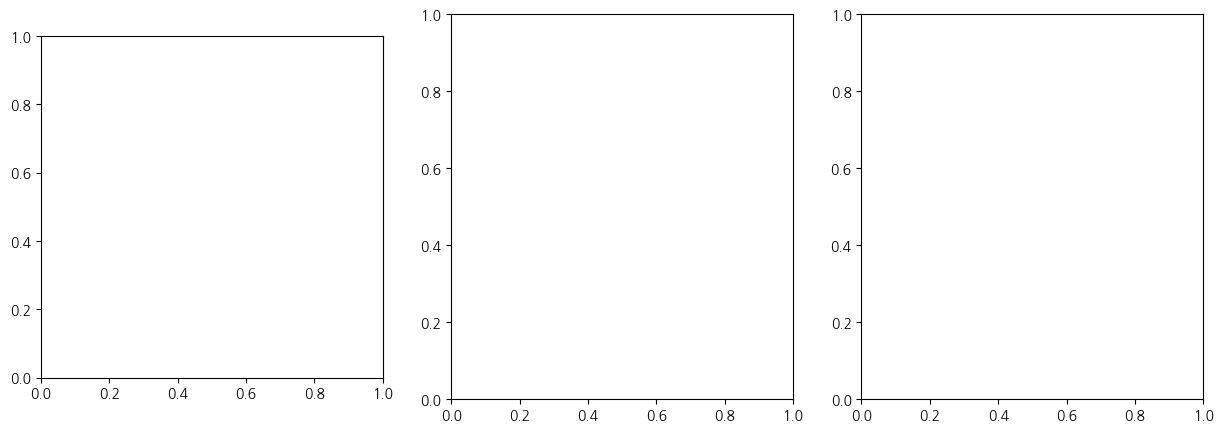

In [14]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn.image import resample_to_img
from nilearn.input_data import NiftiMasker
import matplotlib.pyplot as plt
import torch
import gzip

def preprocess_oasis(fmriprep_dir, metadata_file, output_dir, normalization_method='z-score', background_threshold=2, sample_subject=None):
    # 메타데이터 파일 읽기
    metadata = pd.read_csv(metadata_file)

    # 피험자별로 전처리 수행
    for subject_dir in os.listdir(fmriprep_dir):
        if subject_dir.startswith("sub-") and not subject_dir.endswith(".html"):
            subject_id = subject_dir.split('-')[1]
            # 'OAS' 접두어가 이미 포함되어 있는지 확인
            full_subject_id = subject_id if subject_id.startswith('OAS') else f"OAS{subject_id}"
            subject_metadata = metadata[metadata['OASISID'] == full_subject_id]

            if subject_metadata.empty:
                print(f"Skipping subject {subject_id} due to missing metadata. Check if {full_subject_id} exists in metadata.")
                continue

            if sample_subject is not None and subject_id != sample_subject:
                continue

            for session in os.listdir(os.path.join(fmriprep_dir, subject_dir)):
                if session.startswith("ses-"):
                    session_dir = os.path.join(fmriprep_dir, subject_dir, session)
                    func_dir = os.path.join(session_dir, "func")
                    anat_dir = os.path.join(session_dir, "anat")

                    func_file = os.path.join(func_dir, f"{subject_dir}_{session}_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz")
                    mask_file = os.path.join(anat_dir, f"{subject_dir}_{session}_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz")

                    if not os.path.exists(func_file) or not os.path.exists(mask_file):
                        print(f"Skipping subject {subject_id} due to missing files.")
                        continue
                    # fMRI 데이터 로드
                    fmri_data = nib.load(func_file)

                    # TR 값 추출
                    tr = fmri_data.header.get_zooms()[-1]

                    # fMRI 데이터 전처리
                    fmri_data_resampled = resample_to_img(fmri_data, target_img=mask_file, interpolation='continuous')

                    masker = NiftiMasker(mask_img=mask_file, standardize=True, detrend=True, low_pass=0.08, high_pass=0.01, t_r=tr)
                    fmri_data_masked = masker.fit_transform(fmri_data_resampled)

                    # 배경 복셀 제거
                    background = fmri_data_masked.mean(axis=0) < np.percentile(fmri_data_masked.mean(axis=0), background_threshold)
                    fmri_data_masked[:, background] = 0

                    # 정규화 방법 적용
                    if normalization_method == 'z-score':
                        fmri_data_norm = (fmri_data_masked - fmri_data_masked.mean(axis=0)) / fmri_data_masked.std(axis=0)
                    elif normalization_method == 'minmax':
                        fmri_data_norm = (fmri_data_masked - fmri_data_masked.min(axis=0)) / (fmri_data_masked.max(axis=0) - fmri_data_masked.min(axis=0))
                    else:
                        raise ValueError(f"Invalid normalization method: {normalization_method}")

                    # fMRI 데이터의 차원이 96 이하인 경우 패딩 추가
                    target_shape = (96, 96, 96)
                    current_shape = masker.inverse_transform(fmri_data_norm[0]).shape

                    # 패딩 사이즈 계산
                    pad_sizes = [(0, max(0, target_dim - current_dim)) for target_dim, current_dim in zip(target_shape, current_shape)]
                    # 패딩을 적용하기 위해 4차원 입력에 맞게 패딩 사이즈 조정
                    pad_sizes = [(0, 0)] + pad_sizes

                    fmri_data_padded = np.pad(masker.inverse_transform(fmri_data_norm).get_fdata(), pad_width=pad_sizes, mode='constant')

                    # PyTorch 텐서로 변환 (16비트 부동 소수점 형식)
                    fmri_data_tensor = torch.from_numpy(fmri_data_padded).half()

                    # 전처리된 데이터 저장
                    output_subject_dir = os.path.join(output_dir, subject_id)
                    os.makedirs(output_subject_dir, exist_ok=True)

                    for i, volume in enumerate(fmri_data_tensor):
                        output_file = os.path.join(output_subject_dir, f"frame_{i}.pt")
                        with gzip.open(output_file + '.gz', 'wb') as f:
                            torch.save(volume, f)

                    # 전처리된 데이터 시각화
                    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
                    slices = [fmri_data_padded.shape[0]//2, fmri_data_padded.shape[1]//2, fmri_data_padded.shape[2]//2]
                    for i, ax in enumerate(axes):
                        if i == 0:
                            ax.imshow(fmri_data_padded[slices[0], :, :], cmap='gray')
                        elif i == 1:
                            ax.imshow(fmri_data_padded[:, slices[1], :], cmap='gray')
                        else:
                            ax.imshow(fmri_data_padded[:, :, slices[2]], cmap='gray')
                        ax.set_title(f"Slice {i+1}")
                        ax.axis('off')
                    plt.suptitle(f"Preprocessed fMRI Data - Subject {subject_id}")
                    plt.tight_layout()
                    plt.show()

                    print(f"Preprocessed subject: {subject_id}")
                    return  # 샘플로 한 명의 환자만 처리

    print("Preprocessing completed.")

fmriprep_dir = "/home/minyoungxi/MINYOUNGXI/XFL/OASIS_615_fmriprep_output"
metadata_file = "/home/minyoungxi/MINYOUNGXI/XFL/OASIS_615_fmriprep_output/filtered_data.csv"
output_dir = "/home/minyoungxi/MINYOUNGXI/XFL/OASIS_preprocessing"
normalization_method = 'z-score'  # 'z-score' 또는 'minmax'
background_threshold = 2  # 배경 복셀 제거 시 사용할 백분위 임계값
sample_subject = "OAS30173"  # 샘플로 확인하고자 하는 피험자의 ID

preprocess_oasis(fmriprep_dir, metadata_file, output_dir, normalization_method, background_threshold, sample_subject)


Data shape: (229, 193, 164)
Data min: 0.0
Data max: 0.0
Data mean: 0.0
Data std: 0.0


/tmp/ipykernel_421113/3653004810.py:45: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
/home/minyoungxi/anaconda3/envs/TorchEnv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


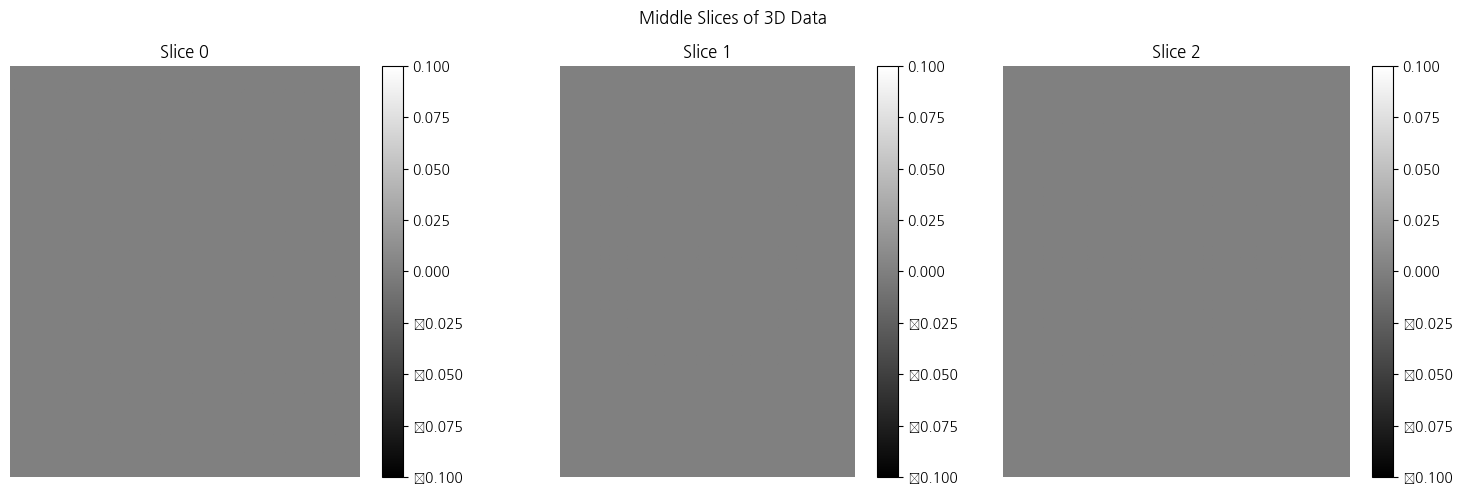

In [17]:
import torch
import gzip
import matplotlib.pyplot as plt

# 압축된 .pt.gz 파일 경로
file_path = '/home/minyoungxi/MINYOUNGXI/XFL/OASIS_preprocessing/OAS30173/frame_177.pt.gz'  # 실제 파일 경로로 변경

# gzip 파일 열기
with gzip.open(file_path, 'rb') as f:
    tensor = torch.load(f)

# 텐서 데이터를 numpy 배열로 변환
data = tensor.numpy()

# 데이터 범위 확인
print("Data shape:", data.shape)
print("Data min:", data.min())
print("Data max:", data.max())
print("Data mean:", data.mean())
print("Data std:", data.std())

# 중간 슬라이스 추출
slice_0 = data[data.shape[0] // 2, :, :]  # 첫 번째 축의 중간 슬라이스
slice_1 = data[:, data.shape[1] // 2, :]  # 두 번째 축의 중간 슬라이스
slice_2 = data[:, :, data.shape[2] // 2]  # 세 번째 축의 중간 슬라이스

# 시각화 (데이터 범위를 명시적으로 설정)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
im0 = axes[0].imshow(slice_0, cmap='gray', vmin=data.min(), vmax=data.max())
axes[0].set_title('Slice 0')
axes[0].axis('off')
fig.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(slice_1, cmap='gray', vmin=data.min(), vmax=data.max())
axes[1].set_title('Slice 1')
axes[1].axis('off')
fig.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(slice_2, cmap='gray', vmin=data.min(), vmax=data.max())
axes[2].set_title('Slice 2')
axes[2].axis('off')
fig.colorbar(im2, ax=axes[2])

plt.suptitle('Middle Slices of 3D Data')
plt.tight_layout()
plt.show()
